In [8]:
import sys
sys.path.append("/users/tom/git/neon_blink_detection/")
sys.path.append("/users/tom/git/neon_blink_detection/src")

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pims

# folder where the data is saved
rec_folder = Path("/users/tom/experiments/neon_blink_detection/datasets/train_data/")

# name of the recording
clip_name = "padel_tennis_neon_03-2ded8f56"

# load video object
vid = pims.Video(str(rec_folder / clip_name / "Neon Sensor Module v1 ps1.mp4"))

deprecated pixel format used, make sure you did set range correctly


In [24]:
import cv2
from itertools import chain
from more_itertools import windowed
from dataclasses import dataclass

@dataclass(unsafe_hash=True, order=True)
class OfParams:
    """Parameters for optical flow calculation"""

    n_layers: int = 1
    layer_interval: int = 5
    average: bool = False
    img_shape: tuple = (64, 64)
    grid_size: int = 10
    step_size: int = 5
    window_size: int = 11
    stop_steps: int = 3

class FeatureCalculator:

    def __init__(self, vid, of_params: OfParams, grid: np.ndarray): 
    
        self.of_params = of_params
        self.grid = grid
        self.vid_obj = self._video_generator(vid)

    def _video_generator(self, vid):

        for frame in vid:

            eye_left_images =  cv2.resize(frame[:, 0:192, 0], (64, 64), interpolation=3)
            eye_right_images =  cv2.resize(frame[:, 192:, 0], (64, 64), interpolation=3)

            yield [np.array(eye_left_images), np.array(eye_right_images)]

    def _optical_flow_stream(self):

        first = next(self.vid_obj)
        stream = chain((self.of_params.step_size + 1) * [first], self.vid_obj)

        for consecutive_frames in windowed(stream, n=self.of_params.step_size + 1):
            previous, current = consecutive_frames[0], consecutive_frames[-1]
            left_prev_image, right_prev_image = previous
            left_curr_image, right_curr_image = current

            args = self.grid, self.of_params.window_size, self.of_params.stop_steps

            # compute optical flow, separately for the left and the right video stream
            optic_flow_left = self._cv2_calcOpticalFlowPyrLK(left_prev_image, left_curr_image, *args)
            optic_flow_right = self._cv2_calcOpticalFlowPyrLK(right_prev_image, right_curr_image, *args)

            # only return the y-component of the optical flow
            yield (optic_flow_left[:, 1], optic_flow_right[:, 1])

    def _cv2_calcOpticalFlowPyrLK(
        img_prev: np.ndarray,
        img_curr: np.ndarray,
        pts_prev: np.ndarray,
        window_size: int,
        stop_steps: int,
    ) -> np.ndarray:
        
        lk_params = dict(
            winSize=(window_size, window_size),
            maxLevel=2,
            criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, stop_steps, 0.03),
        )

        img_prev = img_prev.astype(np.uint8)
        img_curr = img_curr.astype(np.uint8)
        pts_next, _, _ = cv2.calcOpticalFlowPyrLK(
            img_prev, img_curr, pts_prev, None, **lk_params
        )
        return pts_next - pts_prev

    def calculate_optical_flow(self):
        """Compute optical flow for all frames in the video stream."""

        gen = self._optical_flow_stream()
        
        of_left = []
        of_right = []
        # collect all optical flow values
        for of_tuple in gen:
            of_left.append(of_tuple[0])
            of_right.append(of_tuple[1])

        # concatenate left and right optical flow values
        self.of_array = np.concatenate((np.array(of_left), np.array(of_right)), axis=1)

    def concatenate_optical_flow(self, n_layers, layer_interval):
        """Concatenate optical flow values from different frames."""

        def get_layers(n, layer_interval):
            return np.arange(-(n // 2), (n + 1) // 2) * layer_interval

        n_frame = len(self.of_array)
        indices = np.arange(n_frame)
        
        layers = get_layers(n_layers, layer_interval)

        indices_layers = np.array([[indices + i] for i in layers]).reshape(len(layers), -1)
        indices_layers = np.clip(indices_layers, 0, len(self.of_array) - 1)
        
        self.feature_array = np.concatenate(
            [self.of_array[indices] for indices in indices_layers], axis=1
        )

<font size = 4>**(0) Define basic functions for loading video and computing optical flow**

In [40]:

import copy
import typing as T


def create_grid(img_shape: T.Tuple[int, int], grid_size: int) -> np.ndarray:
    x = np.linspace(0, img_shape[1], grid_size, dtype=np.float32)
    y = np.linspace(0, img_shape[0], grid_size, dtype=np.float32)
    xx, yy = np.meshgrid(x, y)
    p_grid = np.concatenate((xx.reshape(-1, 1), yy.reshape(-1, 1)), axis=1)
    p_grid = p_grid[np.all((p_grid != 0) & (p_grid != img_shape[0]), axis=1), :]

    return p_grid


def smooth_proba(proba: np.ndarray, smooth_window) -> np.ndarray:
    proba = proba.copy()
    proba_onset = proba[:, 1]
    proba_offset = proba[:, 2]

    proba_onset = smooth_array(proba_onset, smooth_window)
    proba_offset = smooth_array(proba_offset, smooth_window)
    proba_bg = 1 - np.sum([proba_onset, proba_offset], axis=0)

    proba[:, 0] = proba_bg
    proba[:, 1] = proba_onset
    proba[:, 2] = proba_offset

    return proba


def smooth_array(ary: np.ndarray, smooth_window: int = 1):
    # Define mask and store as an array
    mask = np.ones((1, smooth_window)) / smooth_window
    mask = mask[0, :]
    # Convolve the mask with the raw data
    convolved_data = np.convolve(ary, mask, "same")
    return convolved_data


def classify(probas: np.ndarray):
    pd_labels = np.argmax(probas, axis=1)
    pd_labels[probas[:, 2] > 0.25] = 2
    pd_labels[probas[:, 1] > 0.25] = 1

    return pd_labels


@dataclass
class BlinkEvent:
    start_time: int = None
    end_time: int = None
    label: str = None


class EventArray:
    def __init__(self, start_times, end_times, labels):
        assert len(start_times) == len(end_times) == len(labels)

        self.start_times = np.asarray(start_times)
        self.end_times = np.asarray(end_times)
        self.labels = np.asarray(labels)

    @property
    def blink_events(self) -> T.List[BlinkEvent]:
        blink_label = 3
        start_times = self.start_times[self.labels == blink_label]
        end_times = self.end_times[self.labels == blink_label]
        label_name = "Blink"
        return [
            BlinkEvent(start_time, end_time, label_name)
            for start_time, end_time in zip(start_times, end_times)
        ]

    @classmethod
    def from_samples(cls, timestamps, sample_labels, mapping=None):
        """Creates an instance from a time-series of labelled samples."""
        assert len(timestamps) == len(sample_labels)
        # assert is_sorted(timestamps)

        timestamps = np.asarray(timestamps)
        sample_labels = np.asarray(sample_labels)

        now_unequal_previous = sample_labels[1:] != sample_labels[:-1]
        now_unequal_previous = np.insert(now_unequal_previous, 0, True)

        start_times = timestamps[now_unequal_previous]
        labels = sample_labels[now_unequal_previous]

        end_times = np.roll(start_times, -1)
        end_times[-1] = timestamps[-1]

        if mapping:
            labels = np.array(list(map(lambda e: mapping[e], labels)))

        return cls(start_times, end_times, labels)

    def insert_event(self, start_time: float, end_time: float, label):

        overlapping = (self.start_times < end_time) & (self.end_times > start_time)
        overlapping_ind = np.nonzero(overlapping)[0]

        assert (
            len(overlapping_ind) == 1
        ), "Currently, can insert events only in the middle of existing events, i.e. when there is only 1 overlapping event."

        # cut the overlapping event in the middle and remember end time and label
        ind = overlapping_ind[0]
        previous_end_time = self.end_times[ind]
        previous_label = self.labels[ind]

        self.end_times[ind] = start_time  # cut

        # add two new events:
        #   - the requested event at the start and end time
        #   - a "fill event" which has has the same label as the event which has been
        #   cut and which fills the t0 to the next event
        self.start_times = np.insert(self.start_times, ind + 1, [start_time, end_time])
        self.end_times = np.insert(
            self.end_times, ind + 1, [end_time, previous_end_time]
        )
        self.labels = np.insert(self.labels, ind + 1, [label, previous_label])

    def combine_same_events(self) -> None:
        """Delete events which have the same label as the previous event."""

        equal_previous = self.labels[1:] == self.labels[:-1]
        equal_previous = np.insert(equal_previous, 0, False)
        self.labels = self.labels[~equal_previous]
        self.start_times = self.start_times[~equal_previous]

        # reconstruct end times from start times
        final_time = self.end_times[-1]
        self.end_times = np.roll(self.start_times, -1)
        self.end_times[-1] = final_time

    def remove_events(self, del_mask) -> None:
        # remember boundaries of time axis (start and end times of first and last event)
        initial_time = self.start_times[0]
        final_time = self.end_times[-1]

        # filter events
        self.labels = self.labels[~del_mask]
        self.start_times = self.start_times[~del_mask]

        self.combine_same_events()

        # fix events at the boundaries (if first or last event were removed)
        # last event must stop at the end of the time axis
        self.end_times[-1] = final_time
        # first event must start at the first samples
        self.start_times[0] = initial_time

    @property
    def duration_s(self):
        return self.end_times - self.start_times

    def copy(self):
        """Returns a copied instance of this object."""
        start_times = copy.deepcopy(self.start_times)
        end_times = copy.deepcopy(self.end_times)
        labels = copy.deepcopy(self.labels)
        return EventArray(start_times, end_times, labels)


def filter_wrong_sequence(array: EventArray, max_gap_duration_s=None) -> EventArray:
    none_idx = np.where(array.labels == 0)[0]
    onset_idx = np.where(array.labels == 1)[0]
    offset_idx = np.where(array.labels == 2)[0]

    keep_onset_idx = list(set(onset_idx) & set(offset_idx - 1))
    keep_offset_idx = [i + 1 for i in keep_onset_idx]

    # Discard blink events with long gap between onset and offset
    if max_gap_duration_s is not None:
        onset_idx_gap = list(set(onset_idx) & set(none_idx - 1) & set(offset_idx - 2))
        if onset_idx_gap:
            onset_idx_gap = np.asarray(onset_idx_gap)
            none = onset_idx_gap + 1
            onset_idx_gap = onset_idx_gap[array.duration_s[none] < max_gap_duration_s]
            keep_onset_idx += onset_idx_gap.tolist()
            keep_offset_idx += [i + 2 for i in onset_idx_gap]

    filtered_array = EventArray([array.start_times[0]], [array.end_times[-1]], [0])
    for start_time, end_time in zip(
        array.start_times[keep_onset_idx], array.end_times[keep_offset_idx]
    ):
        filtered_array.insert_event(start_time, end_time, 3)
    return filtered_array


def filter_short_events(
    array: EventArray, min_len_s: float, select_label
) -> EventArray:
    """Remove short blinks from the sequence."""

    filtered_array = array.copy()
    mask_on = filtered_array.labels == select_label
    mask_short = filtered_array.duration_s < min_len_s
    del_mask = mask_on & mask_short
    filtered_array.remove_events(del_mask)
    return filtered_array


<font size = 4>**(1) Calculate optical flow fields for each frame** <br><br>
<font size = 2>Separately for left and right video frames, then concatenate

In [41]:
# define optical flow parameters
of_params = OfParams(n_layers=5, layer_interval=7, average=False, img_shape=(64, 64), grid_size=4, step_size=7, window_size=15, stop_steps=3)

# define grid for optical flow calculation
grid = create_grid(of_params.img_shape, of_params.grid_size + 2)

# initialize feature calculator object
feature_calculator = FeatureCalculator(vid, of_params, grid)

# calculate optical flow for each frame (feature_calculator.of_array)
# (returns only y component of optical flow)
feature_calculator.calculate_optical_flow()

deprecated pixel format used, make sure you did set range correctly
 (repeated 17466 more times)
deprecated pixel format used, make sure you did set range correctly
deprecated pixel format used, make sure you did set range correctly


<font size = 2>Plot mean optical flow for a given time interval

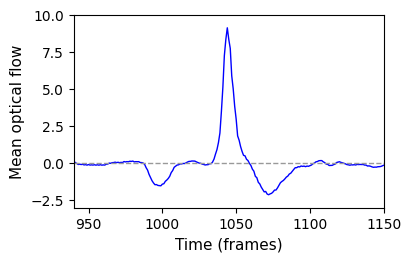

In [26]:
fig, ax = plt.subplots(figsize=(4, 2.5))

mean_optical_flow = np.mean(feature_calculator.of_array, axis=1)
ax.plot(mean_optical_flow, color='blue', linewidth=1)

# Set axis labels and limits
ax.set_xlabel('Time (frames)', fontsize=11)
ax.set_ylabel('Mean optical flow', fontsize=11)
ax.set_xlim(940, 1150)
ax.set_ylim(-3, 10)

# Add horizontal line at y=0
ax.axhline(0, color=[.6, .6, .6], linestyle='--', linewidth=1)

<font size = 4>**(2) Create feature vector** <br><br>
<font size = 2>Optical flow vectors are concatenated across multiple layers (n_layers = 5), with two layers preceeding and two layers following the current frame.<br> The temporal interval corresponds to 35 ms (layer_interval = 7).

In [35]:
n_layers = 5
layer_interval = 7

feature_calculator.concatenate_optical_flow(n_layers, layer_interval)

print("Number of features: {}".format(feature_calculator.feature_array.shape[1]))

Number of features: 360


<font size = 4>**(3) Feed into classifier** <br><br>
<font size = 2>The feature vectors are submitted to the pre-trained XGBoost classifier to generate a time-series of class probabilities.<br>
The three classes are: (1) Background (2) Blink onset (eyelid closing) and (3) Blink offset (eyelid reopening)

Load trained XGBoost classifier:

In [32]:
import joblib

# path to trained classifier
clf_path = "/users/tom/git/neon_blink_detection/weights/xgb.sav"
# load pre-trained classifier
clf = joblib.load(clf_path)
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='mlogloss', gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, tree_method='approx', use_label_encoder=False,
              validate_parameters=1, ...)

Obtain frame-wise class probabilities:

In [33]:
probas = clf.predict_proba(feature_calculator.feature_array)

AttributeError: 'FeatureCalculator' object has no attribute 'feature_array'

<font size = 4>**(4) Temporal smoothing** <br><br>
<font size = 2>Runing average with kernel size of 11 frames

In [123]:
kernel_size = 11
smoothed_proba = smooth_proba(probas, kernel_size)

<font size = 2>Plot blink onset and offset probabilities before and after smoothing 

NameError: name 'smoothed_proba' is not defined

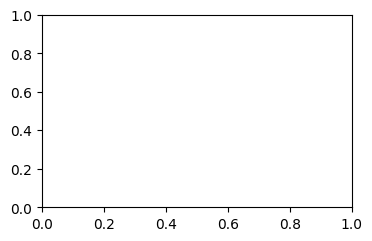

In [20]:
f, ax = plt.subplots(1, 1, figsize=(4, 2.5))

plt.plot(smoothed_proba[:, 1], color="blue", lw=1)
plt.plot(smoothed_proba[:, 2], color="red")
plt.plot(probas[:, 1], color="blue", alpha=0.3)
plt.plot(probas[:, 2], color="red", alpha=0.3)

# horizontal line at 0.25
plt.axhline(0.25, color=[.8, .8, .8], linestyle="--")
plt.legend(["Onset",  "Offset"])
plt.xlim(940, 1150)

<font size = 4>**(5) Discretization** <br><br>
<font size = 2>Turns class probabilities into discrete class predictions

In [147]:
prediction = classify(smoothed_proba)

<font size = 4>**(6) Conversion to events** <br><br>
<font size = 2>Frame-wise predictions are turned into blink events that are submitted to further post-processing

<font size = 3>**(6.1) Filter wrong sequence**

In [226]:
# if gap between onset and offset event is longer than 30 ms, discard the event
max_gap_duration_s = 0.03
timestamps = np.arange(0, len(prediction) / 200

# create event array
event_array_pd = EventArray.from_samples(timestamps, prediction)

# filter wrong sequence (e.g. onset without offset) and events with long gap
blink_array_pd = filter_wrong_sequence(event_array_pd, max_gap_duration_s)

<font size = 3>**(6.2) Filter short events**

In [232]:
# define minimum blink duration
min_len_s = 0.1
# define label for blink events
blink_label = 3

# filter short blinks
blink_array_pd = filter_short_events(blink_array_pd, min_len_s, blink_label)

# get blink events
blink_events = blink_array_pd.blink_events

[BlinkEvent(start_time=0.805, end_time=1.12, label='Blink'),
 BlinkEvent(start_time=5.145, end_time=5.5, label='Blink'),
 BlinkEvent(start_time=6.22, end_time=6.52, label='Blink'),
 BlinkEvent(start_time=7.0, end_time=7.33, label='Blink'),
 BlinkEvent(start_time=7.545, end_time=7.815, label='Blink'),
 BlinkEvent(start_time=8.175, end_time=8.45, label='Blink'),
 BlinkEvent(start_time=8.525, end_time=8.875, label='Blink'),
 BlinkEvent(start_time=9.025, end_time=9.205, label='Blink'),
 BlinkEvent(start_time=9.325, end_time=9.615, label='Blink'),
 BlinkEvent(start_time=9.845, end_time=10.1, label='Blink'),
 BlinkEvent(start_time=11.35, end_time=11.625, label='Blink'),
 BlinkEvent(start_time=13.33, end_time=13.585, label='Blink'),
 BlinkEvent(start_time=15.16, end_time=15.33, label='Blink'),
 BlinkEvent(start_time=15.975, end_time=16.245, label='Blink'),
 BlinkEvent(start_time=16.885, end_time=17.035, label='Blink'),
 BlinkEvent(start_time=17.145, end_time=17.37, label='Blink'),
 BlinkEvent

**Plot mean optical flow and predicted blink events**

In [1]:
np.mean(feature_calculator.of_array, axis=1)

NameError: name 'np' is not defined